**Data mining Project - University of Pisa, acedemic year 2023/24**

**Authors**: Giacomo Aru, Giulia Ghisolfi, Luca Marini, Irene Testa

# Extreme Gradient Boosting Classifier

We import the libraries and define constants and settings of the notebook:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle

from xgboost import XGBClassifier
from xgboost import plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from time import time
from classification_utils import *

RESULTS_DIR = '../data/classification_results'
RANDOM_STATE = 42
clf_name = 'ExtremeGradientBoostingClassifier'

We load the data:

In [2]:
# load the data
incidents_train_df = pd.read_csv('../data/clf_indicators_train.csv', index_col=0)
incidents_test_df = pd.read_csv('../data/clf_indicators_test.csv', index_col=0)
true_labels_train_df = pd.read_csv('../data/clf_y_train.csv', index_col=0)
true_labels_train = true_labels_train_df.values.ravel()
true_labels_test_df = pd.read_csv('../data/clf_y_test.csv', index_col=0)
true_labels_test = true_labels_test_df.values.ravel()

# load the names of the features to use for the classification task
features_for_clf = json.loads(open('../data/clf_indicators_names_rule_based.json').read())

# project on the features to use
indicators_train_df = incidents_train_df[features_for_clf]
indicators_test_df = incidents_test_df[features_for_clf]

We display the features names we will use:

In [3]:
print(features_for_clf)
print(f'Number of features: {len(features_for_clf)}')

['location_imp', 'x', 'y', 'age_range', 'avg_age', 'n_child_prop', 'n_teen_prop', 'n_males_prop', 'n_participants', 'day', 'day_of_week', 'month', 'year', 'days_from_first_incident', 'poverty_perc', 'democrat', 'gun_law_rank', 'aggression', 'accidental', 'defensive', 'suicide', 'road', 'house', 'school', 'business', 'illegal_holding', 'drug_alcohol', 'officers', 'organized', 'social_reasons', 'abduction']
Number of features: 31


We define a list of the categorical features:

In [4]:
categorical_features = [
    'day', 'day_of_week', 'month', 'year',
    'democrat', 'gun_law_rank',
    'aggression', 'accidental', 'defensive', 'suicide',
    'road', 'house', 'school', 'business',
    'illegal_holding', 'drug_alcohol', 'officers', 'organized', 'social_reasons', 'abduction'
]

Parameters explored:
- min_child_weight: Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning. In linear regression task, this simply corresponds to minimum number of instances needed to be in each node. The larger min_child_weight is, the more conservative the algorithm will be (default=1).
- subsample: Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur once in every boosting iteration (default=1).
- scale_pos_weight: Control the balance of positive and negative weights, useful for unbalanced classes. A typical value to consider: sum(negative instances) / sum(positive instances) (default=1).
- colsample_bytree: is the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed (default=1).
- colsample_bylevel: is the subsample ratio of columns for each level. Subsampling occurs once for every new depth level reached in a tree. Columns are subsampled from the set of columns chosen for the current tree (default=1).
- colsample_bynode: is the subsample ratio of columns for each node (split). Subsampling occurs once every time a new split is evaluated. Columns are subsampled from the set of columns chosen for the current level (default=1).
- max_depth: Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. 0 indicates no limit on depth (default=6).

Fixed parameters (many other parameters can be tuned, here we report only the most important one):
- eta: Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative (default=0.3).

In [5]:
cv_train_size = (4/5)*(indicators_train_df.shape[0])
num_pos_inst = np.unique(true_labels_train, return_counts=True)[1][1]
num_neg_inst = np.unique(true_labels_train, return_counts=True)[1][0]
param_grid = {
    'eta': [0.3],
    'min_child_weight': [1, int(0.01*cv_train_size), int(0.025*cv_train_size), int(0.05*cv_train_size), int(0.1*cv_train_size)],
    'subsample': [0.5, 1],
    'scale_pos_weight': [1, num_neg_inst / num_pos_inst],
    'colsample_bytree': [1],
    'colsample_bylevel': [1],
    'colsample_bynode': [1, np.sqrt(len(features_for_clf))/len(features_for_clf)],
    'max_depth': [4, 6, 8]
}

gs = GridSearchCV(
    XGBClassifier(),
    param_grid=param_grid,
    n_jobs=-1,
    scoring=make_scorer(f1_score),
    verbose=10,
    cv=5, # uses a stratified 5-fold cv to validate the models
    refit=False
)
gs.fit(indicators_train_df, true_labels_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 1/5; 1/120] START colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, eta=0.3, max_depth=4, min_child_weight=1, scale_pos_weight=1, subsample=0.5
[CV 5/5; 1/120] START colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, eta=0.3, max_depth=4, min_child_weight=1, scale_pos_weight=1, subsample=0.5
[CV 4/5; 1/120] START colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, eta=0.3, max_depth=4, min_child_weight=1, scale_pos_weight=1, subsample=0.5
[CV 3/5; 1/120] START colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, eta=0.3, max_depth=4, min_child_weight=1, scale_pos_weight=1, subsample=0.5
[CV 2/5; 1/120] START colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, eta=0.3, max_depth=4, min_child_weight=1, scale_pos_weight=1, subsample=0.5
[CV 1/5; 2/120] START colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, eta=0.3, max_depth=4, min_child_weight=1, scale_pos_weight=

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bylevel': [1], 'colsample_bynode': [1, 1.0],
                         'colsample_bytree': [1], 'eta': [0.3],
                         'max_depth': [4, 6, 8],
                         'min_child_weight': [1, 704, 1760, 3520, 7040],
                         'scale_pos_weight': [1, 2.1236912156166814],
                         'subsample': [0.5, 1]},
             refit=False, scoring=make_scorer(f1_score), verbose=10)

We display the grid search results:

In [6]:
cv_results_df = pd.DataFrame(gs.cv_results_)
cv_results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bylevel,param_colsample_bynode,param_colsample_bytree,param_eta,param_max_depth,param_min_child_weight,...,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,7.529757,0.168047,0.025478,0.002829,1,1,1,0.3,4,1,...,0.5,"{'colsample_bylevel': 1, 'colsample_bynode': 1...",0.563296,0.570984,0.566135,0.569783,0.558928,0.565825,0.004390,39
1,6.484625,0.053076,0.024581,0.003684,1,1,1,0.3,4,1,...,1,"{'colsample_bylevel': 1, 'colsample_bynode': 1...",0.560799,0.567982,0.565860,0.569759,0.557161,0.564312,0.004669,41
2,7.448950,0.066665,0.025475,0.003677,1,1,1,0.3,4,1,...,0.5,"{'colsample_bylevel': 1, 'colsample_bynode': 1...",0.635057,0.637529,0.623539,0.621769,0.629485,0.629476,0.006175,7
3,6.369243,0.089339,0.025697,0.003916,1,1,1,0.3,4,1,...,1,"{'colsample_bylevel': 1, 'colsample_bynode': 1...",0.638675,0.637523,0.627979,0.626204,0.632985,0.632673,0.004970,3
4,6.928901,0.107191,0.039904,0.003742,1,1,1,0.3,4,704,...,0.5,"{'colsample_bylevel': 1, 'colsample_bynode': 1...",0.468513,0.484540,0.473930,0.478222,0.456542,0.472349,0.009489,77


We visualize the interaction of hyperparameters through a heatmap:

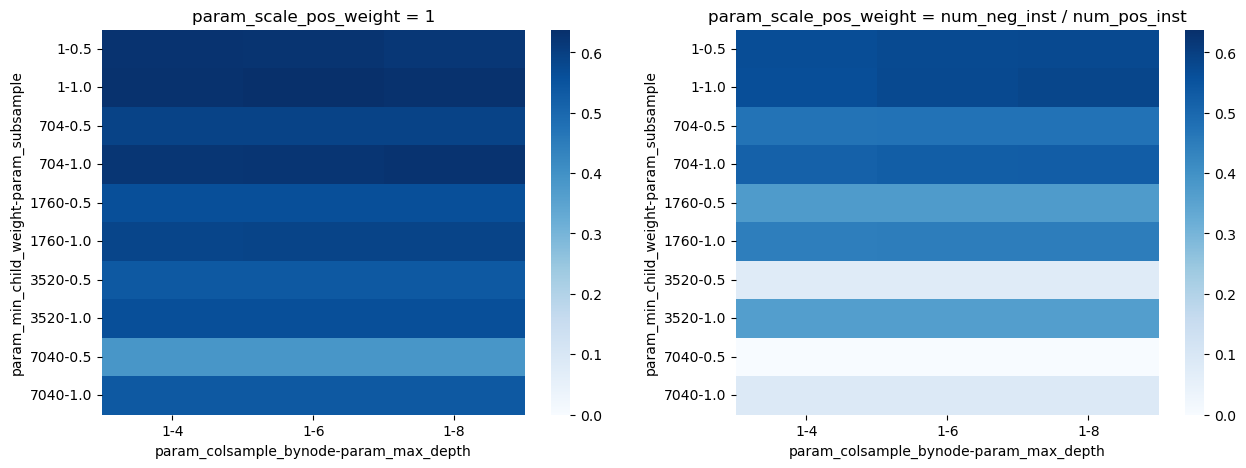

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
pvt_balanced = pd.pivot_table(
    cv_results_df[(cv_results_df['param_scale_pos_weight'] == 1)],
    values='mean_test_score',
    index=['param_min_child_weight', 'param_subsample'],
    columns=['param_colsample_bynode', 'param_max_depth']
)
pvt_non_balanced = pd.pivot_table(
    cv_results_df[(cv_results_df['param_scale_pos_weight'] != 1)],
    values='mean_test_score',
    index=['param_min_child_weight', 'param_subsample'],
    columns=['param_colsample_bynode', 'param_max_depth']
)
min_score = cv_results_df['mean_test_score'].min()
max_score = cv_results_df['mean_test_score'].max()
sns.heatmap(pvt_non_balanced, cmap='Blues', ax=axs[0], vmin=min_score, vmax=max_score)
axs[0].set_title('param_scale_pos_weight = 1');
sns.heatmap(pvt_balanced, cmap='Blues', ax=axs[1], vmin=min_score, vmax=max_score)
axs[1].set_title('param_scale_pos_weight = num_neg_inst / num_pos_inst');

We disaply the performance of the top 10 models:

In [8]:
params = [col for col in cv_results_df.columns if 'param_' in col and 'random' not in col]
cv_results_df.sort_values(
    by='mean_test_score',
    ascending=False)[params+['std_test_score', 'mean_test_score']].head(20).style.background_gradient(subset=['std_test_score', 'mean_test_score'], cmap='Blues')

,param_colsample_bylevel,param_colsample_bynode,param_colsample_bytree,param_eta,param_max_depth,param_min_child_weight,param_scale_pos_weight,param_subsample,std_test_score,mean_test_score
83,1,1.000000,1,0.300000,6,1,2.123691,1,0.002902,0.637796
23,1,1,1,0.300000,6,1,2.123691,1,0.002902,0.637796
63,1,1.000000,1,0.300000,4,1,2.123691,1,0.004970,0.632673
3,1,1,1,0.300000,4,1,2.123691,1,0.004970,0.632673
43,1,1,1,0.300000,8,1,2.123691,1,0.003694,0.631259
103,1,1.000000,1,0.300000,8,1,2.123691,1,0.003694,0.631259
2,1,1,1,0.300000,4,1,2.123691,0.500000,0.006175,0.629476
62,1,1.000000,1,0.300000,4,1,2.123691,0.500000,0.006175,0.629476
107,1,1.000000,1,0.300000,8,704,2.123691,1,0.003625,0.629109
47,1,1,1,0.300000,8,704,2.123691,1,0.003625,0.629109


We refit the best model on the whole training set:

In [9]:
best_index = gs.best_index_
best_model_params = cv_results_df.loc[best_index]['params']
best_model = XGBClassifier(**best_model_params)

# fit the model on all the training data
fit_start = time()
best_model.fit(indicators_train_df, true_labels_train)
fit_time = time()-fit_start

# get the predictions on the training data
train_score_start = time()
pred_labels_train = best_model.predict(indicators_train_df)
train_score_time = time()-train_score_start
pred_probas_train = best_model.predict_proba(indicators_train_df)

# get the predictions on the test data
test_score_start = time()
pred_labels_test = best_model.predict(indicators_test_df)
test_score_time = time()-test_score_start
pred_probas_test = best_model.predict_proba(indicators_test_df)

# save the predictions
pd.DataFrame(
    {'labels': pred_labels_test, 'probs': pred_probas_test[:,1]}
).to_csv(f'{RESULTS_DIR}/{clf_name}_preds.csv')

# save the model
file = open(f'{RESULTS_DIR}/{clf_name}.pkl', 'wb')
pickle.dump(obj=best_model, file=file)
file.close()

# save the cv results
best_model_cv_results = pd.DataFrame(cv_results_df.iloc[best_index]).T
best_model_cv_results.index = [clf_name]
best_model_cv_results.to_csv(f'{RESULTS_DIR}/{clf_name}_train_cv_scores.csv')

We display traning and test scores:

In [10]:
compute_clf_scores(
    y_true=true_labels_train,
    y_pred=pred_labels_train,
    train_time=fit_time,
    score_time=train_score_time,
    params=best_model_params,
    prob_pred=pred_probas_train,
    clf_name=clf_name,
    path=f'{RESULTS_DIR}/{clf_name}_train_scores.csv'
)

,precision-Non-Fatal,recall-Non-Fatal,f1-score-Non-Fatal,precision-Fatal,recall-Fatal,f1-score-Fatal,precision-macro avg,recall-macro avg,f1-score-macro avg,precision-weighted avg,recall-weighted avg,f1-score-weighted avg,accuracy,auroc,train_time,score_time,params
ExtremeGradientBoostingClassifier,0.893573,0.764753,0.82416,0.61751,0.806566,0.699489,0.755542,0.78566,0.761824,0.805196,0.778139,0.784248,0.778139,0.871929,1.864253,0.019454,"{'colsample_bylevel': 1, 'colsample_bynode': 1..."


In [11]:
test_scores = compute_clf_scores(
    y_true=true_labels_test,
    y_pred=pred_labels_test,
    train_time=fit_time,
    score_time=test_score_time,
    params=best_model_params,
    prob_pred=pred_probas_test,
    clf_name=clf_name,
    path=f'{RESULTS_DIR}/{clf_name}_test_scores.csv'
)
test_scores

,precision-Non-Fatal,recall-Non-Fatal,f1-score-Non-Fatal,precision-Fatal,recall-Fatal,f1-score-Fatal,precision-macro avg,recall-macro avg,f1-score-macro avg,precision-weighted avg,recall-weighted avg,f1-score-weighted avg,accuracy,auroc,train_time,score_time,params
ExtremeGradientBoostingClassifier,0.851563,0.734608,0.788774,0.56364,0.728047,0.635381,0.707602,0.731328,0.712077,0.759393,0.732508,0.739669,0.732508,0.81588,1.864253,0.011735,"{'colsample_bylevel': 1, 'colsample_bynode': 1..."


We load the dataset randomly oversampled:

In [12]:
indicators_over_train_df = pd.read_csv('../data/clf_indicators_train_over.csv', index_col=0)
indicators_over_train_df = indicators_over_train_df[features_for_clf]
true_labels_over_train = pd.read_csv('../data/clf_y_train_over.csv', index_col=0).values.ravel()

We fit and test the best model on the oversampled dataset:

In [13]:
# fit the model on all the training data
best_model_over = XGBClassifier(**best_model_params)
fit_start = time()
best_model_over.fit(indicators_over_train_df, true_labels_over_train)
fit_over_time = time()-fit_start

# get the predictions on the training data
train_score_start = time()
pred_labels_over_train = best_model_over.predict(indicators_over_train_df)
train_score_over_time = time()-train_score_start
pred_probas_over_train = best_model_over.predict_proba(indicators_over_train_df)

# get the predictions on the test data
test_score_start = time()
pred_labels_over_test = best_model_over.predict(indicators_test_df)
test_score_over_time = time()-test_score_start
pred_probas_over_test = best_model_over.predict_proba(indicators_test_df)

# save the predictions
pd.DataFrame(
    {'labels': pred_labels_over_test, 'probs': pred_probas_over_test[:,1]}
).to_csv(f'{RESULTS_DIR}/{clf_name}_oversample_preds.csv')

# save the model
file = open(f'{RESULTS_DIR}/{clf_name}_oversample.pkl', 'wb')
pickle.dump(obj=best_model_over, file=file)
file.close()

We load the dataset oversampled with SMOTE:

In [14]:
indicators_smote_train_df = pd.read_csv('../data/clf_indicators_train_smote.csv', index_col=0)
indicators_smote_train_df = indicators_smote_train_df[features_for_clf]
true_labels_smote_train = pd.read_csv('../data/clf_y_train_smote.csv', index_col=0).values.ravel()

We train and test the best model on the SMOTE dataset:

In [15]:
# fit the model on all the training data
best_model_smote = XGBClassifier(**best_model_params)
fit_start = time()
best_model_smote.fit(indicators_smote_train_df, true_labels_smote_train)
fit_smote_time = time()-fit_start

# get the predictions on the training data
train_score_start = time()
pred_labels_smote_train = best_model_smote.predict(indicators_smote_train_df)
train_score_smote_time = time()-train_score_start
pred_probas_smote_train = best_model_smote.predict_proba(indicators_smote_train_df)

# get the predictions on the test data
test_score_start = time()
pred_labels_smote_test = best_model_smote.predict(indicators_test_df)
test_score_smote_time = time()-test_score_start
pred_probas_smote_test = best_model_smote.predict_proba(indicators_test_df)

# save the predictions
pd.DataFrame(
    {'labels': pred_labels_smote_test, 'probs': pred_probas_smote_test[:,1]}
).to_csv(f'{RESULTS_DIR}/{clf_name}_smote_preds.csv')

# save the model
file = open(f'{RESULTS_DIR}/{clf_name}_smote.pkl', 'wb')
pickle.dump(obj=best_model_smote, file=file)
file.close()

We compare the performance of the best model on the three datasets:

In [16]:
test_over_scores = compute_clf_scores(
    y_true=true_labels_test,
    y_pred=pred_labels_over_test,
    train_time=fit_over_time,
    score_time=test_score_over_time,
    params=best_model_params,
    prob_pred=pred_probas_over_test,
    clf_name=clf_name+' over',
    path=f'{RESULTS_DIR}/{clf_name}_over_test_scores.csv'
)

test_smote_scores = compute_clf_scores(
    y_true=true_labels_test,
    y_pred=pred_labels_smote_test,
    train_time=fit_smote_time,
    score_time=test_score_smote_time,
    params=best_model_params,
    prob_pred=pred_probas_smote_test,
    clf_name=clf_name+' SMOTE',
    path=f'{RESULTS_DIR}/{clf_name}_smote_test_scores.csv'
)

pd.concat([test_scores, test_over_scores, test_smote_scores])

,precision-Non-Fatal,recall-Non-Fatal,f1-score-Non-Fatal,precision-Fatal,recall-Fatal,f1-score-Fatal,precision-macro avg,recall-macro avg,f1-score-macro avg,precision-weighted avg,recall-weighted avg,f1-score-weighted avg,accuracy,auroc,train_time,score_time,params
ExtremeGradientBoostingClassifier,0.851563,0.734608,0.788774,0.563640,0.728047,0.635381,0.707602,0.731328,0.712077,0.759393,0.732508,0.739669,0.732508,0.815880,1.864253,0.011735,"{'colsample_bylevel': 1, 'colsample_bynode': 1..."
ExtremeGradientBoostingClassifier over,0.878737,0.645498,0.744272,0.518522,0.810818,0.632535,0.698629,0.728158,0.688404,0.763424,0.698421,0.708502,0.698421,0.816433,2.223538,0.010435,"{'colsample_bylevel': 1, 'colsample_bynode': 1..."
ExtremeGradientBoostingClassifier SMOTE,0.857849,0.719099,0.782370,0.555955,0.746930,0.637446,0.706902,0.733014,0.709908,0.761206,0.728008,0.735976,0.728008,0.816482,2.062805,0.012154,"{'colsample_bylevel': 1, 'colsample_bynode': 1..."


We display a tree:

<Axes: >

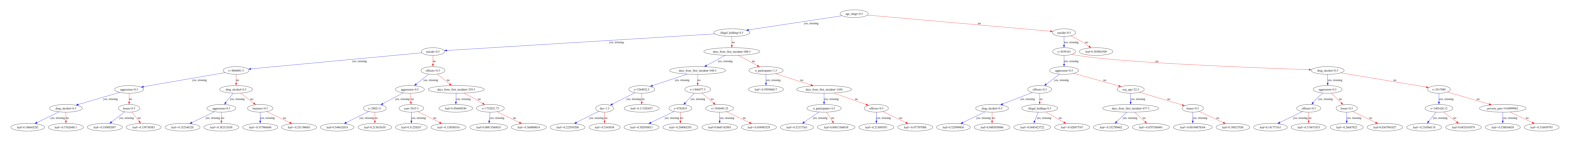

In [17]:
fig, axs = plt.subplots(figsize=(20, 50))
plot_tree(best_model, num_trees=0, ax=axs)

We display another tree:

<Axes: >

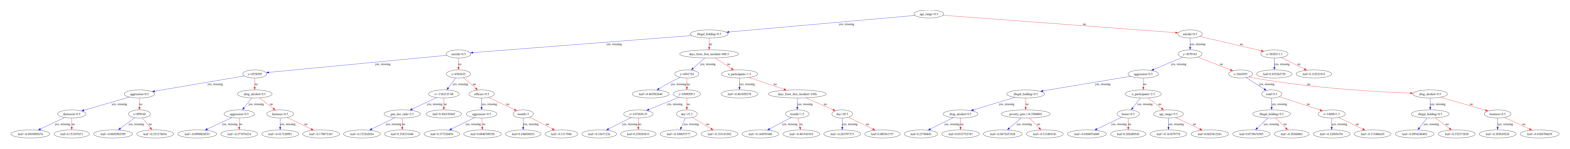

In [18]:
fig, axs = plt.subplots(figsize=(20, 40))
plot_tree(best_model, num_trees=1, ax=axs)

We display the feature importances:

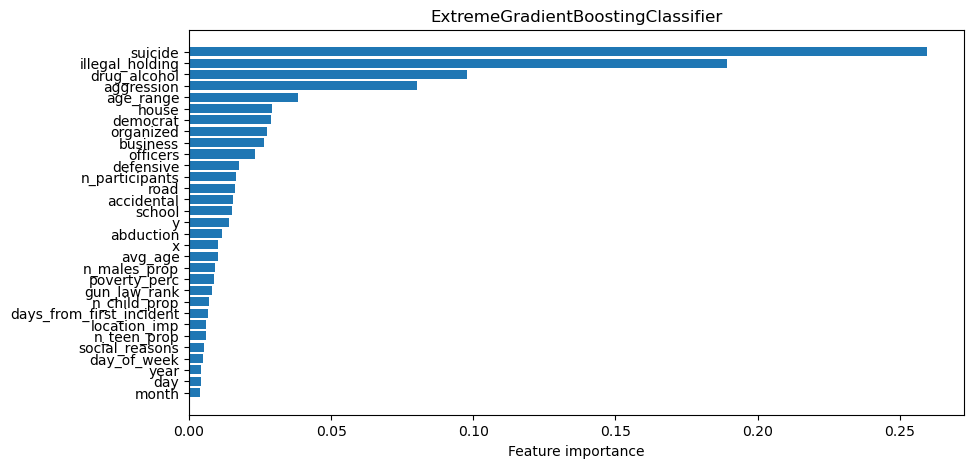

In [19]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
display_feature_importances(
    feature_names=indicators_train_df.columns,
    feature_importances=best_model.feature_importances_,
    axs=axs,
    title=clf_name,
    path=f'{RESULTS_DIR}/{clf_name}_feature_importances.csv'
)

We display confusion matrices:

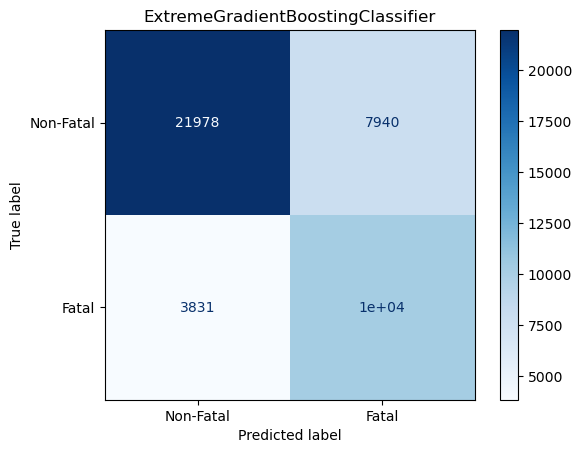

In [20]:
plot_confusion_matrix(
    y_true=true_labels_test,
    y_pred=pred_labels_test,
    title=clf_name
)

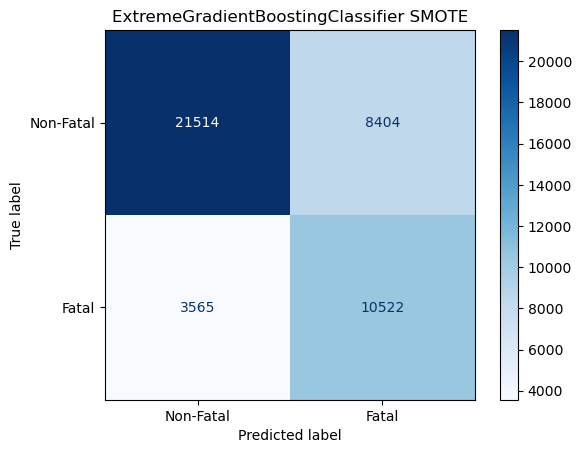

In [21]:
plot_confusion_matrix(
    y_true=true_labels_test,
    y_pred=pred_labels_smote_test,
    title=clf_name + ' SMOTE'
)

We plot incidents (actual class and predicted class) in different feature spaces:

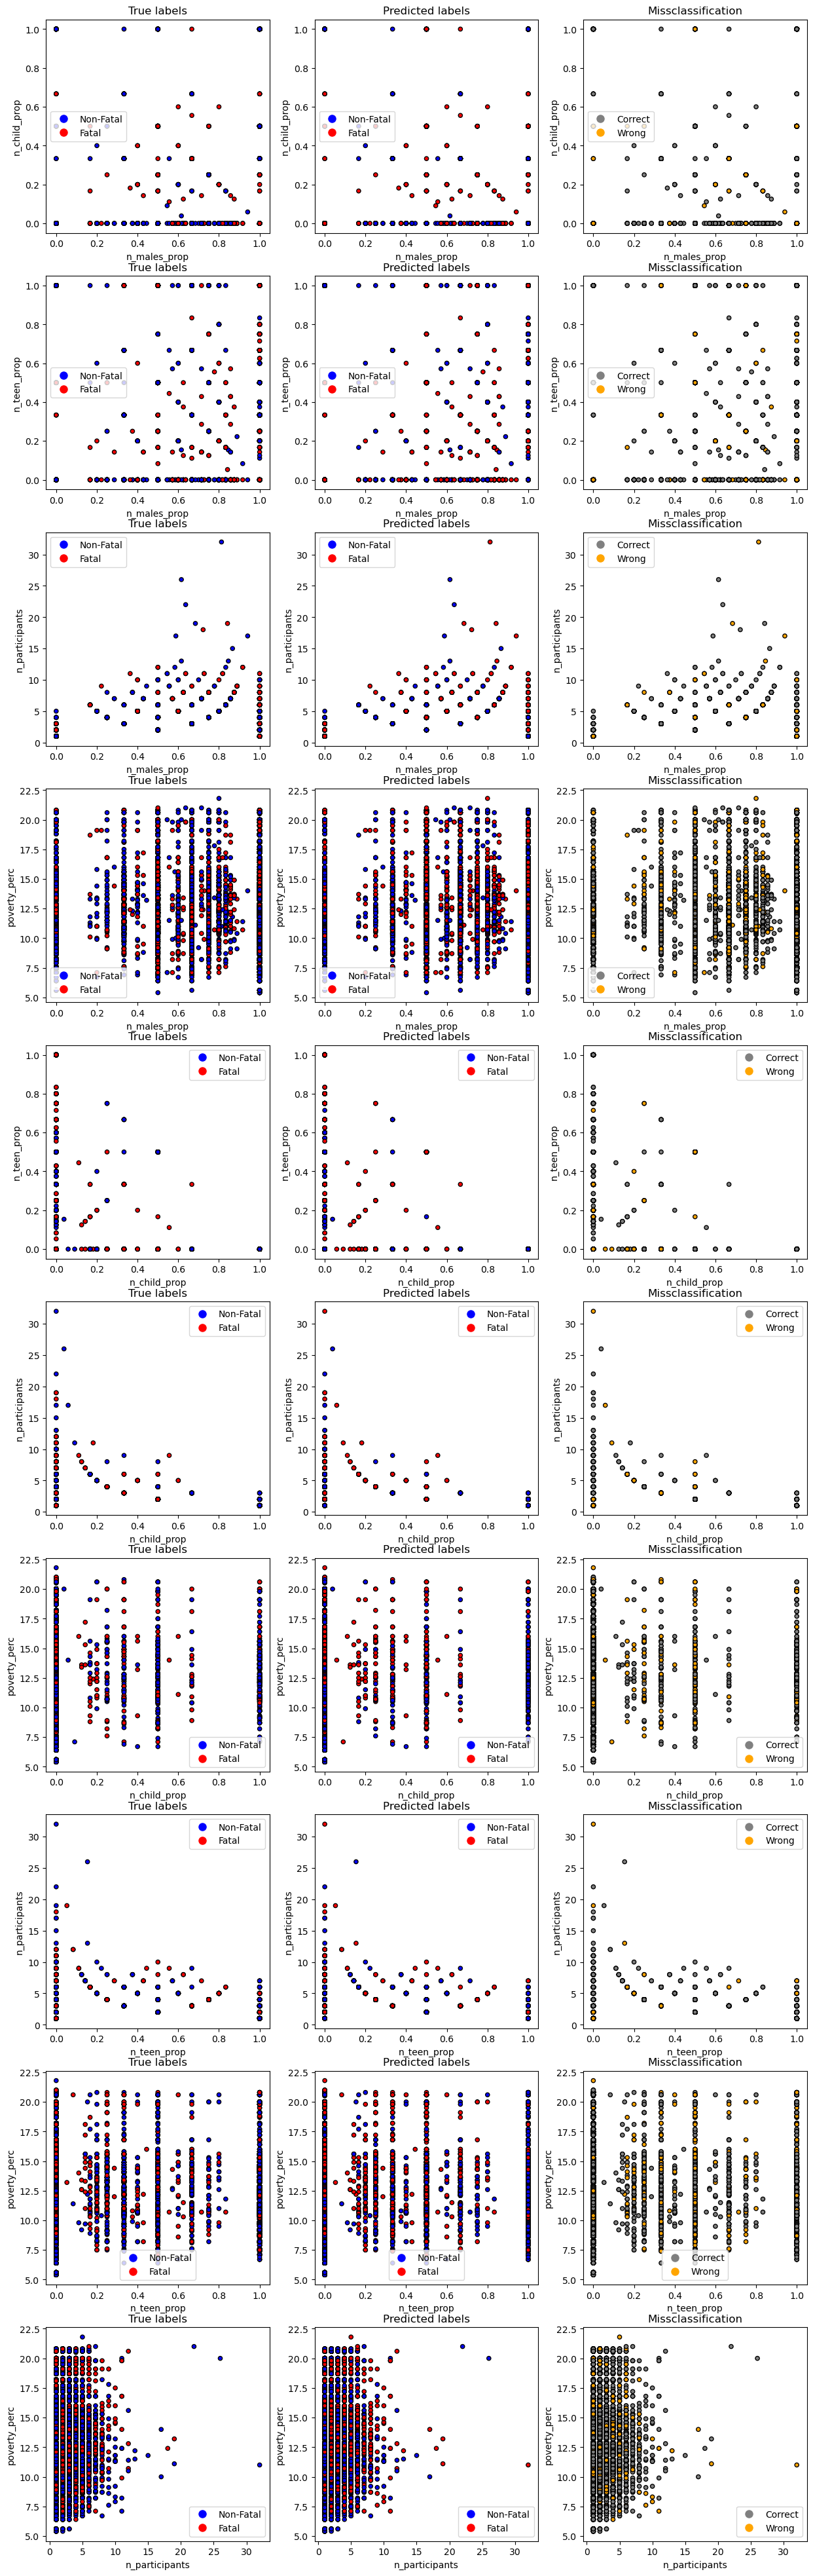

In [22]:
plot_predictions_in_features_space(
    df=incidents_test_df,
    features=['n_males_prop', 'n_child_prop', 'n_teen_prop', 'n_participants', 'poverty_perc'],
    true_labels=true_labels_test,
    pred_labels=pred_labels_test,
    figsize=(15, 50)
)

We plot the ROC curve:

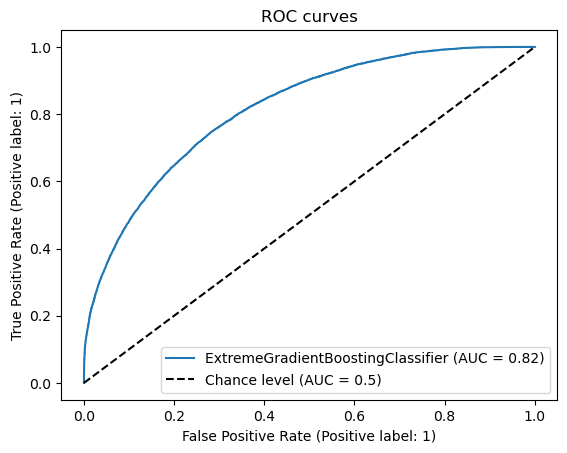

In [23]:
plot_roc(y_true=true_labels_test, y_probs=[pred_probas_test[:,1]], names=[clf_name])

We plot the decision boundaries:

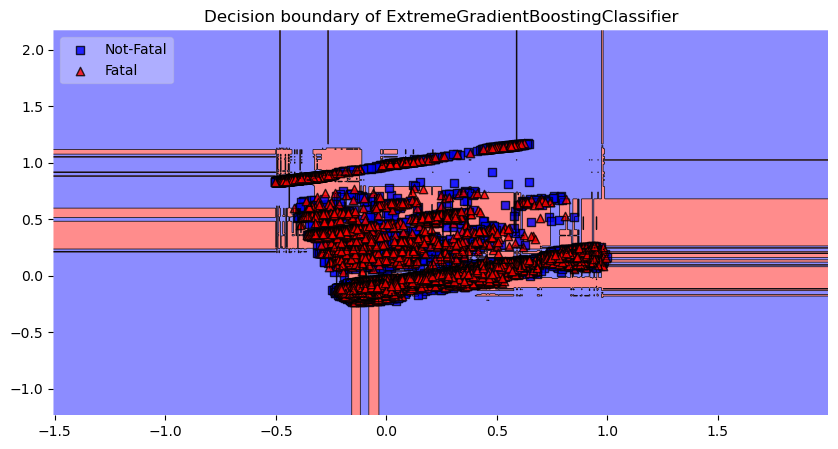

In [24]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
plot_PCA_decision_boundary(
  train_set=indicators_train_df,
  features=[col for col in indicators_train_df.columns if col not in categorical_features],
  train_label=true_labels_train,
  classifier=best_model,
  classifier_name=clf_name,
  axs=axs,
  scale=True,
  pca=True
)

We plot the learning curve:

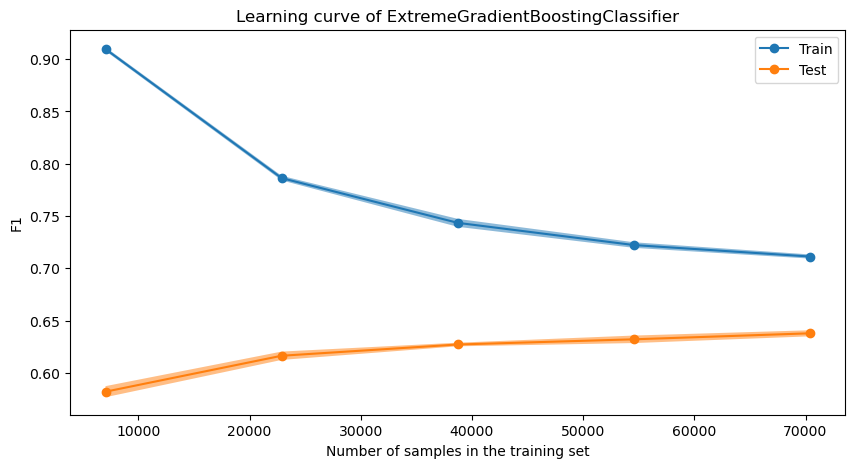

In [25]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
plot_learning_curve(
    classifier=best_model,
    classifier_name=clf_name,
    train_set=indicators_train_df,
    labels=true_labels_train,
    ax=axs,
    train_sizes=np.linspace(0.1, 1.0, 5),
    metric='f1'
)

We plot the performance of the best model varying the complexity parameters:

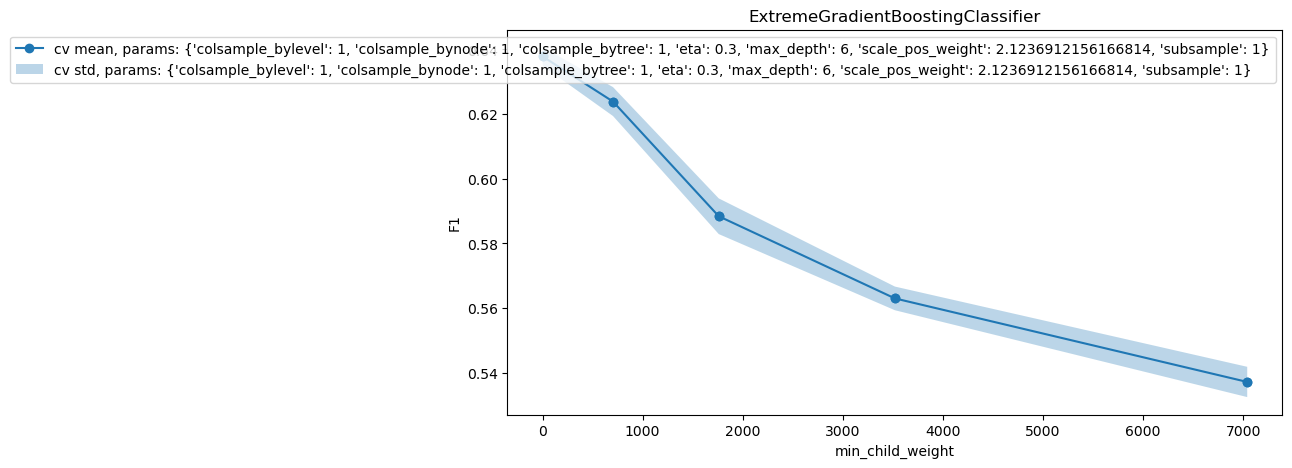

In [26]:
param_of_interest = 'min_child_weight'
fixed_params = best_model_params.copy()
fixed_params.pop(param_of_interest)
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
plot_scores_varying_params(
    cv_results_df,
    param_of_interest,
    fixed_params,
    'F1',
    axs,
    title=clf_name
)

We plot the distribution of the features for misclassified incidents:

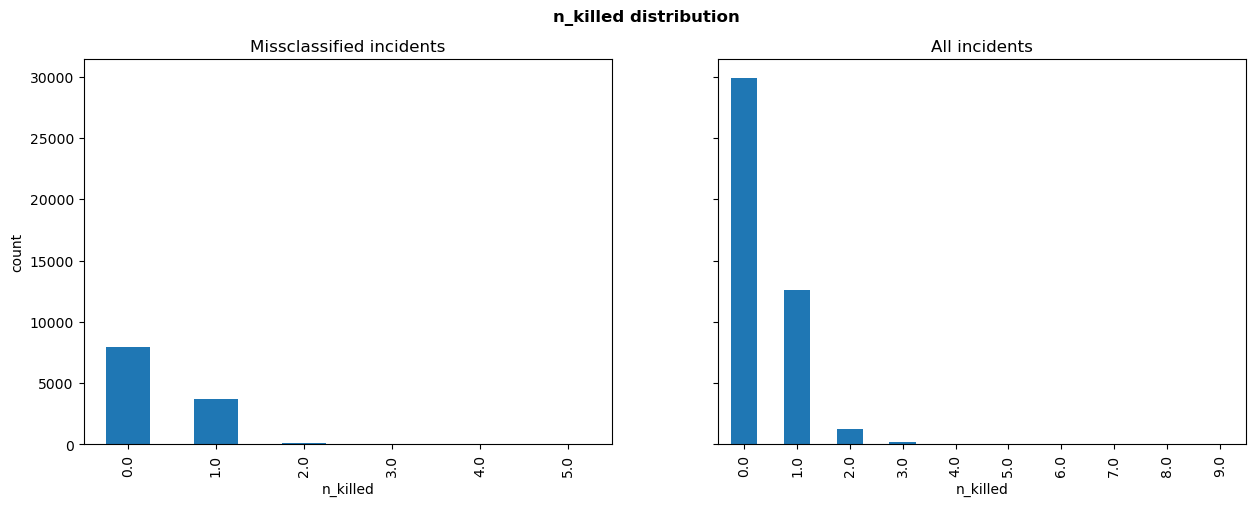

In [27]:
plot_distribution_missclassifications(
    true_labels_test,
    pred_labels_test,
    incidents_test_df,
    'n_killed',
    'bar',
    title='n_killed distribution'
)

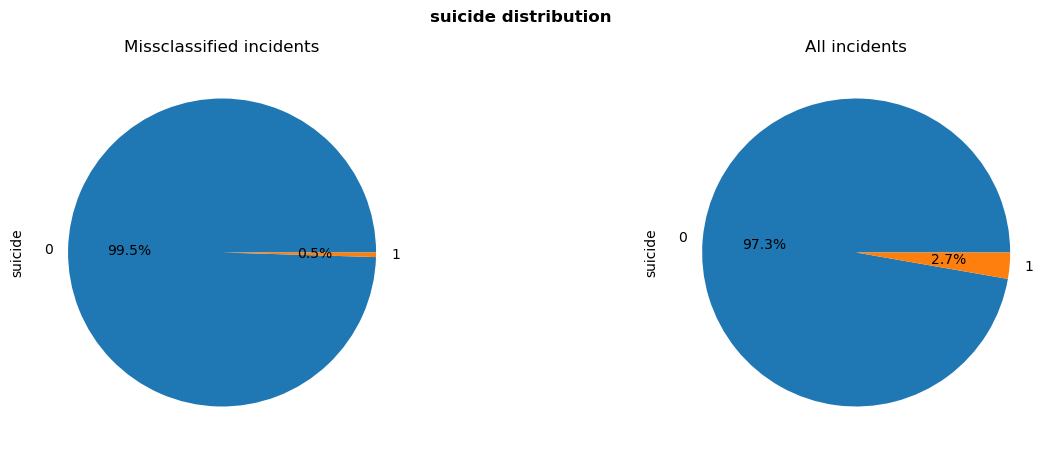

In [28]:
plot_distribution_missclassifications(
    true_labels_test,
    pred_labels_test,
    incidents_test_df,
    'suicide',
    'pie',
    title='suicide distribution'
)

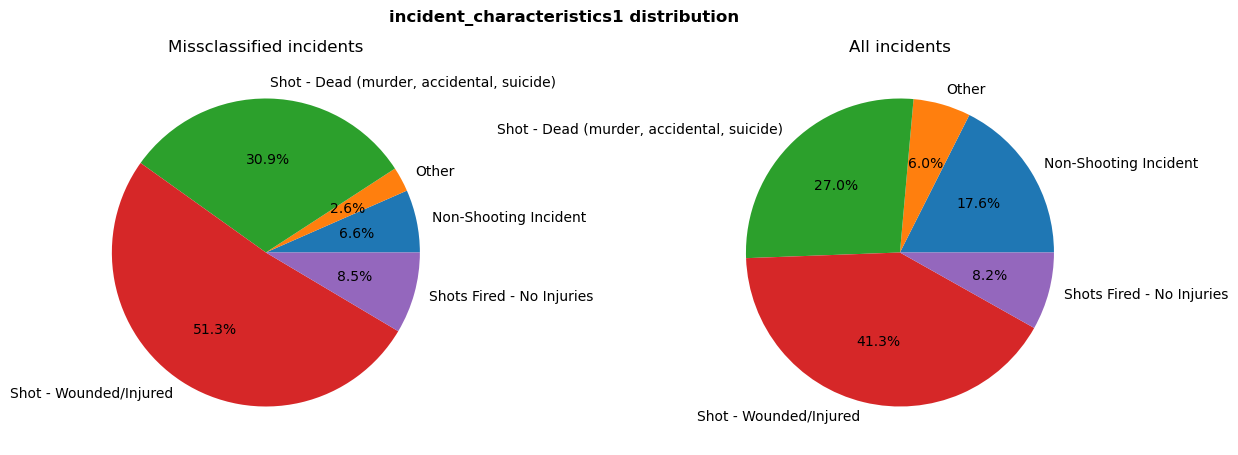

In [29]:
plot_distribution_missclassifications(
    true_labels_test,
    pred_labels_test,
    incidents_test_df,
    'incident_characteristics1',
    'pie',
    title='incident_characteristics1 distribution'
)

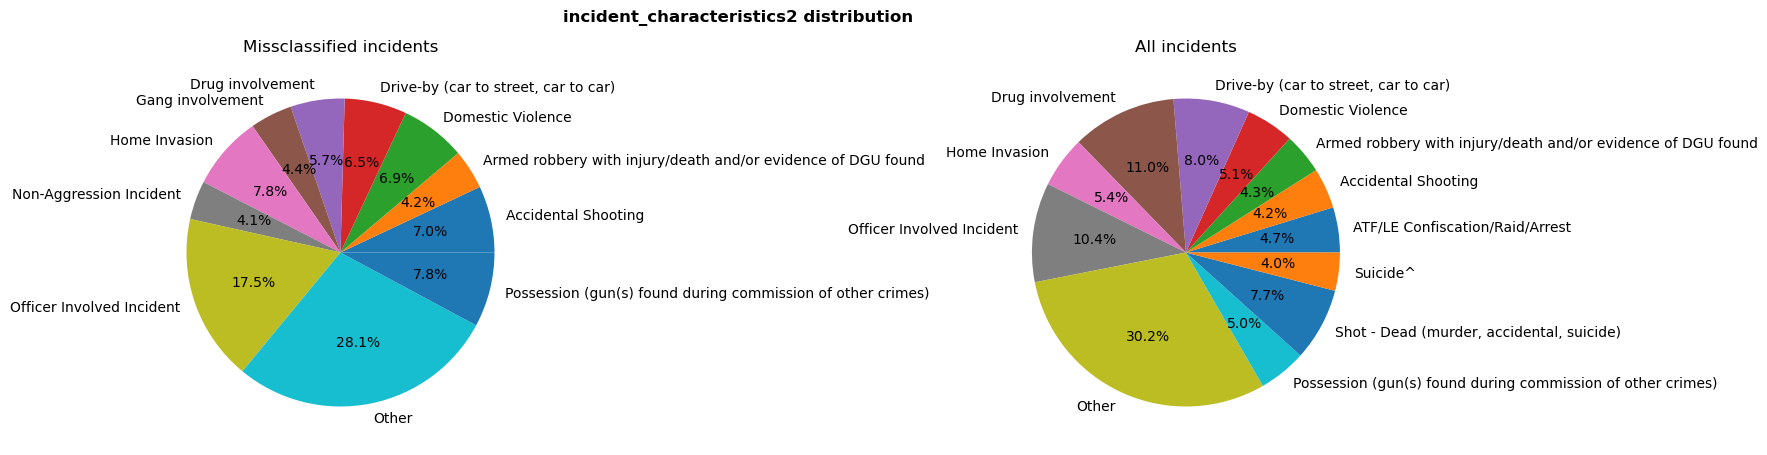

In [30]:
plot_distribution_missclassifications(
    true_labels_test,
    pred_labels_test,
    incidents_test_df,
    'incident_characteristics2',
    'pie',
    pie_perc_threshold=2,
    figsize=(20, 5),
    title='incident_characteristics2 distribution'
)

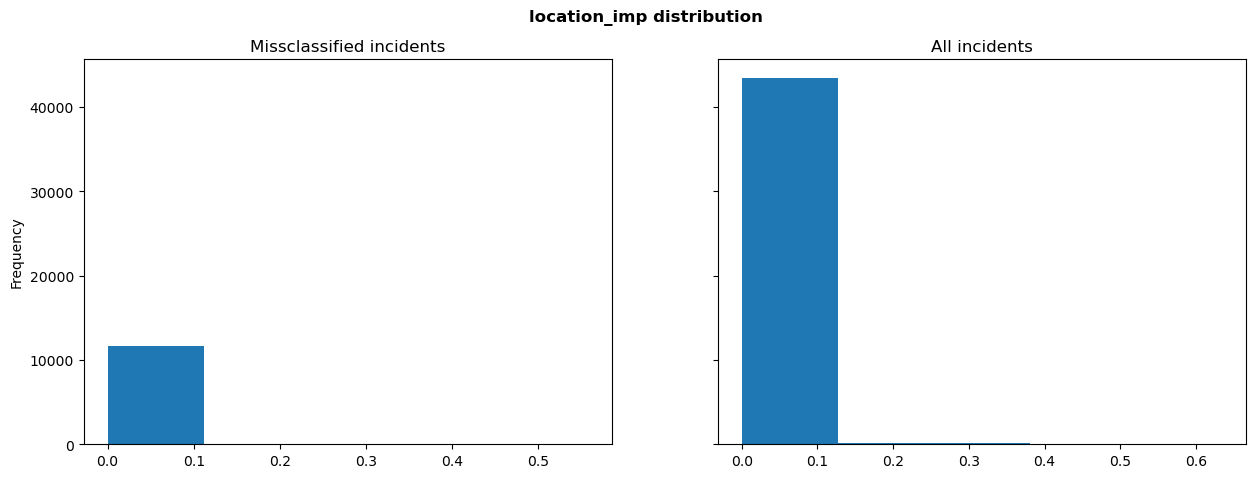

In [31]:
plot_distribution_missclassifications(
    true_labels_test,
    pred_labels_test,
    incidents_test_df,
    'location_imp',
    'hist',
    bins=5,
    title='location_imp distribution'
)